# Set up
This section should be interacted with. Use `data_path` to designate the folder where the OpenBARR data is. This folder needs to be formatted beforehand - take a look at the **README** or see `/sample_data/original_data` for an example. Change `output_path` to a folder where you want the graphs and the data used to make them.

Here, you will also specify the experimental conditions in `conditions` and days in `days`. This will help the program navigate the files and batch process.


In [1]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

# import packages we need for analysis and graphing
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# specify where the data is
data_path = '/content/drive/MyDrive/0 Revamp/sample_data/original_data'
output_path = '/content/drive/MyDrive/0 Revamp/sample_data/output'

# specify experimental conditions
conditions = ['3EtOH', '25EtOH', '50EtOH'] #'75EtOH'
days = ['D1', 'D2', 'D3']

# specify binning parameters
bin_size, total_time = 60, 900
bins_array = bin_size*np.arange(total_time/bin_size+1)

# specify some aesthetic stuff
colors = [
    ['#4188C5', '#326EA3', '#26547C'],  # for condition 0, 3EtOH, days 1, 2, and 3
    ['#F47C98', '#F16284', '#EF476F'],  # for condition 1, 25Etoh, days 1, 2, and 3
    ['#FFDE92', '#FFD87C', '#FFD166'],  # ...
    # ['#35FAC5', '#0CF9BA', '#06D6A0']
  ]

# in case you have data preprocessed already
# tracking_df = pd.read_csv(os.path.join(output_path, 'tracking_df.csv'))
# bouts_df = pd.read_csv(os.path.join(output_path, 'bouts_df.csv'))
# bins_df = pd.read_csv(os.path.join(output_path, 'bins_df.csv'))

Mounted at /content/drive


# Preprocess the data
We read in and format the OpenBARR data to be more understandable and remove the first second of data in case of initial mistracking.

In [2]:
def read_raw(file_path):
  """Read an OpenBARR file.

  Reads a tab-delimited OpenBARR file and specifies the column names.

  Parameters
  ----------
  file_path : str
    The path to the OpenBARR file.

  Returns
  -------
  pandas.DataFrame
    A DataFrame containing the data from the OpenBARR file.
  """
  return pd.read_csv(file_path, sep='\t', header=None,
                     names=['time', 'x', 'y', 'in', 'entry', 'exit'])

def adjust_y(df):
  """Adjust the y-coordinates of an OpenBARR dataframe.

  Adjusts the y-coordinates of an OpenBARR dataframe relative to the border of
  ROSA and RONSA. Where y >= 0 indicates how far animal is in ROSA while y < 0
  indicate how far animal is in RONSA. This adjustment makes the data more
  intuitive and easier to analyze.

  Parameters
  ----------
  df : pandas.DataFrame
    A DataFrame containing the data from the OpenBARR file.

  Notes
  -----
  This works under the assumption, in short, that the OpenBARR is set up in the
  exact same way. Common problems could be flipped ROSA/RONSA causing RONSA to
  be >= 0 and ROSA <0 and camera height differences could change the arbitrary
  coordinates, affecting the adjustment for a fly never entering ROSA.
  """
  border = df[df['entry'] == 1]['y']  # get y-coords when fly initially enters ROSA
  if len(border) > 0:  # if fly was ever in ROSA
    df.loc[:, 'y'] = max(border) - df['y']  # the adjustment
  else:  # if the fly never entered ROSA,
    df.loc[:, 'y'] = 235 - df['y']  # use upper-bound estimate - see notes

def preprocess(file_path):
  """Preprocess an OpenBARR file.

  Reads an OpenBARR file, removes the first second of data, and adjusts the
  y-coordinates relative to the border of ROSA and RONSA.

  Parameters
  ----------
  file_path : str
    The path to the OpenBARR file.

  Returns
  -------
  pandas.DataFrame
    A DataFrame containing the preprocessed data from the OpenBARR file.
  """
  df = read_raw(file_path)
  df = df[df['time'] >= 1]
  adjust_y(df)
  return df.reset_index(drop=True)

def get_bouts(df, bins=None):
  """Retrieve bout data for an OpenBARR dataframe.

  Extracts bout data to make some analyses easier. A bout is defined as a
  continuous portion of time in ROSA or RONSA.

  Parameters
  ----------
  df : pandas.DataFrame
    A DataFrame containing the preprocessed data from the OpenBARR file.
  bins : np.array, optional
    A list containing the bins to further split the data

  Returns
  -------
  pandas.DataFrame
    A DataFrame containing bout data.

  """
  # normalizer to convert OpenBARR's arbitrary coordinates to cm
  normalizer = 50

  # determine where bouts start/end and sort for easy iteration
  indices = None
  if bins is None:
    indices = np.sort(np.unique(np.concatenate([0, np.where(df['entry'] == 1)[0], np.where(df['exit'] == 1)[0], df.shape[0]-1], axis=None)))
  else:
    indices = np.sort(np.unique(np.concatenate([np.where(df['entry'] == 1)[0],
                                                np.where(df['exit'] == 1)[0],
                                                [np.where((df['time'].reset_index(drop=True) - bin) >= 0)[0][0] for bin in bins],
                                                df.shape[0]-1], axis=None)))

  bout_indicator, bout_num = df.loc[indices[0], 'in'], 0
  running_max_depth, running_sample_timer = 0, 0
  bouts = pd.DataFrame(columns=['bout', 'in', 'start', 'end', 'duration', 'max depth', 'distance', 'speed', 'entry', 'sample'])
  for i in range(indices.size-1):
    # where this bout starts and ends
    start, end = indices[i], indices[i+1]

    # where next bout starts and ends
    next_start, next_end, future_bout_indicator = None, None, None
    if i+1 < indices.size-1:
      next_start, next_end = indices[i+1], indices[i+2]
      future_bout_indicator = df.loc[next_start, 'in']

    # get data on whether this bout was in ROSA or RONSA
    in_rosa = df.loc[start, 'in']

    # reset data on past bouts if this is a new bout in a new region
    if bout_indicator != in_rosa:
      bout_num += 1  # track bouts by change in region, not change in bins
      bout_indicator = in_rosa  # update prev. bout indicator for next bout
      running_max_depth, running_sample_timer = 0, 0  # reset previous depth and sample data

    # compute bout duration
    start_time, end_time = df.loc[start, 'time'], df.loc[end-1, 'time']
    duration = end_time - start_time

    # get max depth for bout
    depth = np.max([np.max(np.abs(df.loc[start:end, 'y']))/normalizer,  # max depth for this bout
                    running_max_depth,  # max depth for previous bout, non-zero when previous bout was in same region
                    np.max(np.abs(df.loc[next_start:next_end, 'y']))/normalizer if future_bout_indicator == in_rosa else 0])  # max depth for future bout, non-zero if future bout is in same region
    running_max_depth = depth  # update the prev. depth for next bout

    # compute total distance traveled in a bout
    dist = np.sum(np.linalg.norm(np.subtract(df.iloc[start+1:end][['x', 'y']].reset_index(drop=True),
                                              df.iloc[start:end-1][['x', 'y']].reset_index(drop=True)),
                                  axis=1))/normalizer

    # compute speed for a bout
    speed = dist/duration if duration > 0 else 0

    # determine if this bout was an entry
    entry = 1 if in_rosa == 1 and i != 0 else 0

    # determine if this bout was a sample
    future_bout_time = df.loc[next_end-1, 'time'] - df.loc[next_start, 'time'] if future_bout_indicator == in_rosa else 0  # compute time for next bout if in same region
    sample = 1 if duration + running_sample_timer + future_bout_time <= 2 and in_rosa == 1 else 0  # sample if duration of this bout summed with the duration of the next/past bouts that are also in same region, is less 2 seconds
    running_sample_timer = duration  # update the prev. sample timer for next bout

    # create row for this bout
    bouts.loc[bouts.shape[0]] = [bout_num, in_rosa, start_time, end_time, duration, depth, dist, speed, entry, sample]
  return bouts

def get_quantiles(bouts_data, conditions, day=days[-1], rosa=1, target_col='duration', agg_func='sum', n_c=4, labels=None):
  """Get quantiles for bouts data.

  Assigns and returns quantiles bouts data. Which conditions, the day, rosa,
  target column, and aggregate function are specified. Default settings are
  quartiles for flies that are in ROSA the most in the last day.

  Parameters
  ----------
  bouts_data : pandas.DataFrame
    A DataFrame containing bout data created in the "Preprocess the data" step
  conditions : list
    A list of condition names specified initially
  day : str, default = days[-1]
    The day to get the quantiles for, default is last day
  rosa : int, default = 1
    1 (meaning in ROSA) or 0 (meaning in RONSA)
  target_col : str, default = 'duration'
    The name of the column of interest from the bouts data
  agg_func : str, default = 'sum'
    The name of a pandas aggregate function like "sum" and "mean"
  n_c : int, default = 4
    How many quantiles you want to split the data into
  labels : list, default = None
    The names you want to assign to the quantiles

  Returns
  -------
  bouts_data : pandas.DataFrame
    A DataFrame containing bout data with quantiles assigned
  q_df : pandas.DataFrame
    A DataFrame containing quantiles for reference
  """
  # filter bouts data by day to get the data used to determine quartiles
  filtered_df = bouts_data[(bouts_data['day'] == day) & (bouts_data['in'] == rosa)]

  # aggregate the filtered data
  agg_df = filtered_df.groupby(['condition', 'id']).agg({target_col:agg_func})

  # get bins and assign quantiles for each condition
  q_df = None
  for condition in conditions:
    assignments, bins = pd.qcut(agg_df.loc[condition, target_col], n_c, labels=labels, retbins=True)
    assigned_q = pd.DataFrame({'condition':condition, 'id':agg_df.loc[condition].index, 'quantile':assignments}).reset_index(drop=True)

    if q_df is None:
      q_df = assigned_q
    else:
      q_df = pd.concat([q_df, assigned_q], ignore_index=True)

  # assign the quantiles to bouts data
  bouts_data = bouts_data.merge(q_df[['condition', 'id', 'quantile']], on=['condition', 'id'], how='left')

  return bouts_data, q_df

In [3]:
# read in all the data and put them into dataframes for analysis
tracking_df, bouts_df, bins_df = None, None, None
for condition in conditions:
  for day in days:
    temp_path = os.path.join(data_path, condition, day)
    print('Processing files in', temp_path)
    for a_file in os.listdir(temp_path):
      temp_df = preprocess(os.path.join(temp_path, a_file)).reset_index(drop=True)

      # take preprocessed file, label, and add to the big preprocessed df
      temp_df.loc[:, ['condition', 'day', 'id']] = condition, day, a_file
      if tracking_df is None:
        tracking_df = temp_df.copy()
      else:
        tracking_df = pd.concat([tracking_df, temp_df], ignore_index=True)

      # take preprocessed file, get bouts, label, and add to bouts df
      temp_bouts = get_bouts(temp_df)
      temp_bouts.loc[:, ['condition', 'day', 'id']] = condition, day, a_file
      if bouts_df is None:
        bouts_df = temp_bouts.copy()
      else:
        bouts_df = pd.concat([bouts_df, temp_bouts], ignore_index=True)

      # take preprocessed file, get bouts, label, and add to bouts df
      temp_bins = get_bouts(temp_df, bins=bins_array[:-1])
      temp_bins.loc[:, ['condition', 'day', 'id']] = condition, day, a_file
      if bouts_df is None:
        bins_df = temp_bins.copy()
      else:
        bins_df = pd.concat([bins_df, temp_bins], ignore_index=True)

    print(len(os.listdir(temp_path)), 'files processed\n')

# clean up ids column to allow for matching - may not be necessary depending on your naming scheme
# we drop the file extension and day
tracking_df['id'] = tracking_df['id'].str[:-7]
bouts_df['id'] = bouts_df['id'].str[:-7]
bins_df['id'] = bins_df['id'].str[:-7]

# uncomment below if you want to save newly built dfs for reference
# tracking_df.to_csv(os.path.join(output_path, 'tracking_df.csv'), index=False)
# bouts_df.to_csv(os.path.join(output_path, 'bouts_df.csv'), index=False)
# bins_df.to_csv(os.path.join(output_path, 'bins_df.csv'), index=False)

Processing files in /content/drive/MyDrive/0 Revamp/sample_data/original_data/3EtOH/D1
84 files processed

Processing files in /content/drive/MyDrive/0 Revamp/sample_data/original_data/3EtOH/D2
84 files processed

Processing files in /content/drive/MyDrive/0 Revamp/sample_data/original_data/3EtOH/D3
84 files processed

Processing files in /content/drive/MyDrive/0 Revamp/sample_data/original_data/25EtOH/D1
81 files processed

Processing files in /content/drive/MyDrive/0 Revamp/sample_data/original_data/25EtOH/D2
82 files processed

Processing files in /content/drive/MyDrive/0 Revamp/sample_data/original_data/25EtOH/D3
82 files processed

Processing files in /content/drive/MyDrive/0 Revamp/sample_data/original_data/50EtOH/D1
87 files processed

Processing files in /content/drive/MyDrive/0 Revamp/sample_data/original_data/50EtOH/D2
89 files processed

Processing files in /content/drive/MyDrive/0 Revamp/sample_data/original_data/50EtOH/D3
88 files processed



# Graph the data

## Scatter Bar Plots



In [ ]:
def scatter_bar_plot(bouts_data, conditions, days, rosa, target_col, agg_func, colors, ylim_top=None, ylab='default ylab', plot_title='default title'):
  """Create a scatter bar plot.

  Creates a scatter bar plot using bout data. The data plotted is specified by
  commonly analyzed variables such as when the fly is in ROSA, bout duration,
  distance traveled, etc. Aggregate functions can also be specified and are used
  to summarize your variable of interest. Data used to produce the graph is
  outputed and a pdf of the graph is saved to your specified output path.

  Parameters
  ----------
  bouts_data : pandas.DataFrame
    A DataFrame containing bout data created in the "Preprocess the data" step
  conditions : list
    A list of condition names specified initially
  days : list
    A list of day names specified initially
  rosa : int
    1 (meaning in ROSA) or 0 (meaning in RONSA)
  target_col : str
    The name of the column of interest from the bouts data
  agg_func : str
    The name of a pandas aggregate function like "sum" and "mean"
  colors : list
    2d list of colors to use for each condition and day
  ylim_top : int, default = None
    The max value of the y-axis for the plot
  ylab : str, default = 'default ylab'
    The y-axis label
  plot_title : str, default = 'default title'
    The title of the plot - also used to name the output files
  """
  # variables for plot transparency, width of columns, and angle of x labels
  t, w, ang = 0.8, 0.25, 20

  # create the grid for the multiple plots
  fig, ax = plt.subplots(1, len(days), sharey=True, figsize=(2*len(days), 6))
  x = np.arange(len(conditions))*w

  # aggregate data for graphing
  agg_bouts_df = bouts_data[bouts_data['in'] == rosa]  # filter by rosa
  agg_bouts_df = agg_bouts_df.groupby(['condition', 'day', 'in', 'id']).agg({target_col:agg_func})

  for i, day in enumerate(days):
    for j, condition in enumerate(conditions):
      # select condition, day, and rosa from the aggregated data
      temp_data = agg_bouts_df.loc[(condition, day, rosa)]

      # use the selected data to scatter plot a single "bar"
      ax[i].scatter(j*w+np.random.uniform(-0.05, 0.05, len(temp_data)), temp_data, color=colors[j][i], alpha=t)

    # labeling and aesthetic for a day's particular graph
    ax[i].set_xticks(x, labels=conditions, rotation=ang)
    ax[i].set_title(day)
    ax[i].spines[['right', 'top']].set_visible(False)

  # more labeling and standardizing of yaxis
  ax[0].set_ylim(0, ylim_top)
  ax[0].set_ylabel(ylab)
  fig.suptitle(plot_title)

  # save the data used for graphing
  save = agg_bouts_df.reset_index().pivot(index=['condition', 'in', 'id'], columns='day', values=target_col).reset_index()
  save.to_csv(os.path.join(output_path, f'{plot_title}.csv'), index=False)

  # save figure
  fig.savefig(os.path.join(output_path, f'{plot_title}.pdf'), transparent=True)

### Standard Scatter Bar Plots

In [ ]:
# time
# total time spent in rosa/ronsa
scatter_bar_plot(bouts_df, conditions, days, rosa=1, target_col='duration', agg_func='sum',
                 colors=colors, ylab='s', plot_title='Total Time Spent in ROSA')
scatter_bar_plot(bouts_df, conditions, days, rosa=0, target_col='duration', agg_func='sum',
                 colors=colors, ylab='s', plot_title='Total Time Spent in RONSA')

# average time spent in rosa/ronsa, i also specify ylim_top in the rosa case \
# if you need to change the max value of the y-axis
scatter_bar_plot(bouts_df, conditions, days, rosa=1, target_col='duration', agg_func='mean', ylim_top=50,
                 colors=colors, ylab='s', plot_title='Average Time Spent in ROSA')
scatter_bar_plot(bouts_df, conditions, days, rosa=0, target_col='duration', agg_func='mean',
                 colors=colors, ylab='s', plot_title='Average Time Spent in RONSA')

# distance
# total distance traveled in rosa/ronsa
scatter_bar_plot(bouts_df, conditions, days, rosa=1, target_col='distance', agg_func='sum',
                 colors=colors, ylab='cm', plot_title='Total Distance Traveled in ROSA')
scatter_bar_plot(bouts_df, conditions, days, rosa=0, target_col='distance', agg_func='sum',
                 colors=colors, ylab='cm', plot_title='Total Distance Traveled in RONSA')

# average distance traveled in rosa/ronsa
scatter_bar_plot(bouts_df, conditions, days, rosa=1, target_col='distance', agg_func='mean',
                 colors=colors, ylab='cm', plot_title='Average Distance Traveled in ROSA')
scatter_bar_plot(bouts_df, conditions, days, rosa=0, target_col='distance', agg_func='mean',
                 colors=colors, ylab='cm', plot_title='Average Distance Traveled in RONSA')

# average speed across bouts
scatter_bar_plot(bouts_df, conditions, days, rosa=1, target_col='speed', agg_func='mean',
                 colors=colors, ylab='cm/s', plot_title='Average Speed in ROSA')
scatter_bar_plot(bouts_df, conditions, days, rosa=0, target_col='speed', agg_func='mean',
                 colors=colors, ylab='cm/s', plot_title='Average Speed in RONSA')

# total entries to rosa
scatter_bar_plot(bouts_df, conditions, days, rosa=1, target_col='entry', agg_func='sum',
                 colors=colors, ylab='Entries', plot_title='Total Entries to ROSA')

# average max depth in rosa/ronsa, set ylim_top=4 for alignment with openbarr
scatter_bar_plot(bouts_df, conditions, days, rosa=1, target_col='max depth', agg_func='mean', ylim_top=4,
                 colors=colors, ylab='cm', plot_title='Average Depth in ROSA')
scatter_bar_plot(bouts_df, conditions, days, rosa=0, target_col='max depth', agg_func='mean', ylim_top=4,
                 colors=colors, ylab='cm', plot_title='Average Depth in RONSA')

# samples
scatter_bar_plot(bouts_df, conditions, days, rosa=1, target_col='sample', agg_func='sum',
                 colors=colors, ylab='Samples', plot_title='Total Samples')

## Behavior Across Time Plots

In [ ]:
# add bins to the bins df beforehand
bins_df['bin'] = pd.cut(bins_df['start'], bins_array, labels=np.arange(total_time/bin_size)+1)

def beh_time_plot(bins_data, bins, conditions, days, rosa, target_col, agg_func,
                  colors, ylims=(None, None), ylab='default ylab', plot_title='default title'):
  """Create two plots - one across conditions and another across days.

  Creates a behavior across time plot using binned data. The data plotted is
  specified by commonly analyzed variables such as when the fly is in ROSA,
  duration of bout, etc. Aggregate functions can also be specified and are used
  to summarize your variable of interest. Data used to produce the graph is
  outputed and a pdf of the graph is saved to your specified output path.

  Parameters
  ----------
  bins_data : pandas.DataFrame
    A DataFrame containing binned data created in the "Preprocess the data"
    step with bins added beforehand
  bins : np.array
    An array of bin edges
  conditions : list
    A list of condition names specified initially
  days : list
    A list of day names specified initially
  rosa : int
    1 (meaning in ROSA) or 0 (meaning in RONSA)
  target_col : str
    The name of the column of interest from the bins data
  agg_func : str
    The name of a pandas aggregate function
  colors : list
    2d list of colors to use for each condition and day
  ylims : tuple, default = (None, None)
    The min and max values of the y-axis
  ylab : str, default = 'default ylab'
    The y-axis label
  plot_title : str, default = 'default title'
    The title of the plot - also used to name the output files
  """
  # set up x-axis for plotting
  x = np.arange(total_time/bin_size) + 1

  # aggregate data for graphing
  agg_bins_df = bins_data[bins_data['in'] == rosa]  # filter by rosa
  agg_bins_df = agg_bins_df.groupby(['condition', 'day', 'in', 'bin', 'id'], observed=True).agg({target_col:agg_func})

  #-----plots where each individual plot is for a day-----
  # create the grid for the multiple plots with a grid for each day
  fig, ax = plt.subplots(1, len(days), sharey=True, figsize=(8*len(days), 4.5))
  for i, day in enumerate(days):
    for j, condition in enumerate(conditions):
      # select condition, day, and rosa from the aggregated data
      temp_data = agg_bins_df.loc[(condition, day, rosa)].reset_index().groupby('bin', observed=True).agg({target_col:'mean'}).sort_index()
      temp_se = agg_bins_df.loc[(condition, day, rosa)].reset_index().groupby('bin', observed=True).agg({target_col:'sem'}).sort_index()

      # use the selected data to plot a single line for a condition and day
      ax[i].plot(x, temp_data, label=condition, color=colors[j][i])

      # plot error bars
      error_lb, error_ub = (temp_data-temp_se)[target_col], (temp_data+temp_se)[target_col]
      ax[i].fill_between(error_lb.index, error_lb, error_ub, color=colors[j][i], alpha=0.2)

    # labeling and aesthetic for a day's particular graph
    ax[i].set_xticks(x)
    ax[i].set_xlim(x[0], x[-1])
    ax[i].set_title(day)
    ax[i].spines[['right', 'top']].set_visible(False)
  # more labeling and standardizing of yaxis
  ax[0].set_ylim(ylims)
  ax[0].set_ylabel(ylab)
  ax[0].legend()
  fig.suptitle(plot_title)
  # save figure
  fig.savefig(os.path.join(output_path, f'{plot_title} By Condition.pdf'), transparent=True)

  #-----plots where each individual plot is for a condition-----
  # create grid for multiple plots with a grid for each condition
  fig, ax = plt.subplots(1, len(conditions), sharey=True, figsize=(8*len(conditions), 4.5))
  for j, condition in enumerate(conditions):
    for i, day in enumerate(days):
      # select condition, day, and rosa from the aggregated data
      temp_data = agg_bins_df.loc[(condition, day, rosa)].reset_index().groupby('bin', observed=True).agg({target_col:'mean'}).sort_index()
      temp_se = agg_bins_df.loc[(condition, day, rosa)].reset_index().groupby('bin', observed=True).agg({target_col:'sem'}).sort_index()

      # use the selected data to plot a single line for a condition and day
      ax[j].plot(x, temp_data, label=day, color=colors[j][i], linestyle=(0, ((i+1)**2, i)))

      # plot error bars
      error_lb, error_ub = (temp_data-temp_se)[target_col], (temp_data+temp_se)[target_col]
      ax[j].fill_between(error_lb.index, error_lb, error_ub, color=colors[j][i], alpha=0.2)

    # labeling and aesthetic for a day's particular graph
    ax[j].set_xticks(x)
    ax[j].set_xlim(x[0], x[-1])
    ax[j].set_title(condition)
    ax[j].spines[['right', 'top']].set_visible(False)
    ax[j].legend()
  # more labeling and standardizing of yaxis
  ax[0].set_ylim(ylims)
  ax[0].set_ylabel(ylab)
  fig.suptitle(plot_title)
  # save figure
  fig.savefig(os.path.join(output_path, f'{plot_title} By Day.pdf'), transparent=True)

  # save the data used for graphing
  save = agg_bins_df.reset_index().pivot(index=['condition', 'in', 'id', 'bin'], columns='day', values=target_col).reset_index()
  save.to_csv(os.path.join(output_path, f'{plot_title} Line Plot.csv'), index=False)

In [ ]:
# time in rosa/ronsa
beh_time_plot(bins_df, bins_array, conditions, days, rosa=1,
              target_col='duration', agg_func='sum', colors=colors,
              ylab='seconds', plot_title='Time Spent in ROSA')
beh_time_plot(bins_df, bins_array, conditions, days, rosa=0,
              target_col='duration', agg_func='sum', colors=colors,
              ylab='seconds', plot_title='Time Spent in RONSA')

# velocity in rosa/ronsa
beh_time_plot(bins_df, bins_array, conditions, days, rosa=1,
              target_col='speed', agg_func='mean', colors=colors,
              ylab='cm/s', plot_title='Average Speed in ROSA')
beh_time_plot(bins_df, bins_array, conditions, days, rosa=0,
              target_col='speed', agg_func='mean', colors=colors,
              ylab='cm/s', plot_title='Average Speed in RONSA')

# distance moved in rosa/ronsa
beh_time_plot(bins_df, bins_array, conditions, days, rosa=1,
              target_col='distance', agg_func='sum', colors=colors,
              ylab='cm', plot_title='Distance Traveled in ROSA')
beh_time_plot(bins_df, bins_array, conditions, days, rosa=0,
              target_col='distance', agg_func='sum', colors=colors,
              ylab='cm', plot_title='Distance Traveled in RONSA')

# depth in rosa/ronsa
beh_time_plot(bins_df, bins_array, conditions, days, rosa=1,
              target_col='max depth', agg_func='mean', colors=colors,
              ylab='cm', plot_title='Average Depth in ROSA')
beh_time_plot(bins_df, bins_array, conditions, days, rosa=0,
              target_col='max depth', agg_func='mean', colors=colors,
              ylab='cm', plot_title='Average Depth in RONSA')

## Scatter Bar Plots w/ Binning

In [13]:
def scatter_bar_plot_binned(bouts_data, conditions, days, rosa, target_col,
                            agg_func, colors, bin_name='general bins',
                            bin_labels=None, ylim_top=None, ylab='default ylab',
                            plot_title='default title'):
  """Create a scatter bar plot but split by bins.

  Creates a scatter bar plot using bout data that has a binned data column.
  Binning is done before calling this function. The data plotted can be
  by the bout variables and an aggregate function. However, this has only been
  used to count the number of bouts of certain durations.

  Parameters
  ----------
  bouts_data : pandas.DataFrame
    A DataFrame containing bout data created in the "Preprocess the data"
    step with bins added beforehand
  conditions : list
    A list of condition names specified initially
  days : list
    A list of day names specified initially
  rosa : int
    1 (meaning in ROSA) or 0 (meaning in RONSA)
  target_col : str
    The name of the column of interest from the bouts data
  bin_name : str, default = 'general bins'
    The name of the bin columns to be used
  bin_labels : list, default = None
    The names you want to assign to the bins
  agg_func : str
    The name of a pandas aggregate function like "sum" and "mean"
  colors : list
    2d list of colors to use for each condition and day
  ylim_top : int, default = None
    The max value of the y-axis for the plot
  ylab : str, default = 'default ylab'
    The y-axis label
  plot_title : str, default = 'default title'
    The title of the plot - also used to name the output files
  """

  # variables for plot transparency, width of columns, and angle of x labels
  t, w, ang = 0.8, 0.25, 20

  # create the grid for the multiple plots
  bins = bouts_data[bin_name].unique().sort_values()
  fig, ax = plt.subplots(1, len(days), sharey=True, figsize=(len(conditions)*len(days)*2, 6))
  x = np.arange(len(bins))*len(conditions)/2  # multiplied by half the number of conditions to ensure enough space between each bin

  # aggregate data for graphing
  agg_bouts_df = bouts_data[bouts_data['in'] == rosa]
  agg_bouts_df = agg_bouts_df.groupby(['condition', 'day', 'in', bin_name, 'id'], observed=True).agg({target_col:agg_func}).reset_index()

  for i, day in enumerate(days):
    for j, condition in enumerate(conditions):
      for k, bin in enumerate(bins):
        # select condition, day, and rosa from the aggregated data
        temp_data = agg_bouts_df[(agg_bouts_df['condition'] == condition) & (agg_bouts_df['day'] == day) & (agg_bouts_df['in'] == rosa) & (agg_bouts_df[bin_name] == bin)]
        if not temp_data.empty:
          temp_data = temp_data[target_col]
          # use the selected data to scatter plot a single "bar"
          ax[i].scatter(x[k]+j*w+np.random.uniform(-0.05, 0.05, len(temp_data)), temp_data, color=colors[j][i], alpha=t)

    # labeling and aesthetic for a day's particular graph
    if bin_labels is not None:
      ax[i].set_xticks(x+(w*len(conditions)/2), labels=bin_labels, rotation=ang)
    else:
      ax[i].set_xticks(x+(w*len(conditions)/2), labels=bins, rotation=ang)
    ax[i].set_title(day)
    ax[i].spines[['right', 'top']].set_visible(False)

  # more labeling and standardizing of yaxis
  ax[0].set_ylim(0, ylim_top)
  ax[0].set_ylabel(ylab)
  fig.suptitle(plot_title)

  # save the data used for graphing
  save = agg_bouts_df.reset_index().pivot(index=['condition', 'in', 'id', bin_name], columns='day', values=target_col).reset_index()
  save.to_csv(os.path.join(output_path, f'{plot_title}.csv'), index=False)

  # save figure
  fig.savefig(os.path.join(output_path, f'{plot_title}.pdf'), transparent=True)

def scatter_bar_plot_quantile(bouts_data, conditions, days, rosa, target_col,
                              agg_func, colors, bin_name='quantile',
                              bin_labels=None, ylim_top=None, ylab='default ylab',
                              plot_title='default title'):
  """Create a scatter bar plot but split up by quantile.

  Creates a scatter bar plot using bout data that has a split up by quantiles.
  Getting quantiles is done before calling this function. The data plotted can
  be by the bout variables and an aggregate function. This is a slightly
  modified version of the scatter_bar_plot_binned function because quantiles can
  only be compared within a condition. So individual plots look at one condition
  across days.

  Parameters
  ----------
  bouts_data : pandas.DataFrame
    A DataFrame containing bout data created in the "Preprocess the data"
    step with quantiles added beforehand
  conditions : list
    A list of condition names specified initially
  days : list
    A list of day names specified initially
  rosa : int
    1 (meaning in ROSA) or 0 (meaning in RONSA)
  target_col : str
    The name of the column of interest from the bouts data
  bin_name : str, default = 'quantile'
    The name of the bin columns to be used
  bin_labels : list, default = None
    The names you want to assign to the quantiles
  agg_func : str
    The name of a pandas aggregate function like "sum" and "mean"
  colors : list
    2d list of colors to use for each condition and day
  ylim_top : int, default = None
    The max value of the y-axis for the plot
  ylab : str, default = 'default ylab'
    The y-axis label
  plot_title : str, default = 'default title'
    The title of the plot - also used to name the output files
  """

  # variables for plot transparency, width of columns, and angle of x labels
  t, w, ang = 0.8, 0.25, 20

  # create the grid for the multiple plots
  bins = bouts_data.loc[(bouts_data['condition'] == conditions[0]) & (bouts_data['day'] == days[0]), bin_name].sort_values().unique()
  fig, ax = plt.subplots(1, len(conditions), sharey=True, figsize=(len(conditions)*len(days)*2, 6))
  x = np.arange(len(bins))*len(days)/2  # multiplied by half the number of days to ensure enough space between each bin

  # aggregate data for graphing
  agg_bouts_df = bouts_data[bouts_data['in'] == rosa]
  agg_bouts_df = agg_bouts_df.groupby(['condition', 'day', 'in', bin_name, 'id'], observed=True).agg({target_col:agg_func}).reset_index()

  for j, condition in enumerate(conditions):
    for i, day in enumerate(days):
      bins = bouts_data.loc[(bouts_data['condition'] == condition) & (bouts_data['day'] == day), bin_name].sort_values().unique()
      for k, bin in enumerate(bins):
        # select condition, day, and rosa from the aggregated data
        temp_data = agg_bouts_df[(agg_bouts_df['condition'] == condition) & (agg_bouts_df['day'] == day) & (agg_bouts_df['in'] == rosa) & (agg_bouts_df[bin_name] == bin)]
        if not temp_data.empty:
          temp_data = temp_data[target_col]
          # use the selected data to scatter plot a single "bar"
          ax[j].scatter(x[k]+i*w+np.random.uniform(-0.05, 0.05, len(temp_data)), temp_data, color=colors[j][i], alpha=t)

    # labeling and aesthetic for a day's particular graph
    if bin_labels is not None:
      ax[j].set_xticks(x+(w*len(days)/2), labels=bin_labels, rotation=ang)
    else:
      ax[j].set_xticks(x+(w*len(days)/2), labels=bins, rotation=ang)
    ax[j].set_title(condition)
    ax[j].spines[['right', 'top']].set_visible(False)

  # more labeling and standardizing of yaxis
  ax[0].set_ylim(0, ylim_top)
  ax[0].set_ylabel(ylab)
  fig.suptitle(plot_title)

  # save the data used for graphing
  save = agg_bouts_df.reset_index().pivot(index=['condition', 'in', 'id', bin_name], columns='day', values=target_col).reset_index()
  save.to_csv(os.path.join(output_path, f'{plot_title}.csv'), index=False)

  # save figure
  fig.savefig(os.path.join(output_path, f'{plot_title}.pdf'), transparent=True)

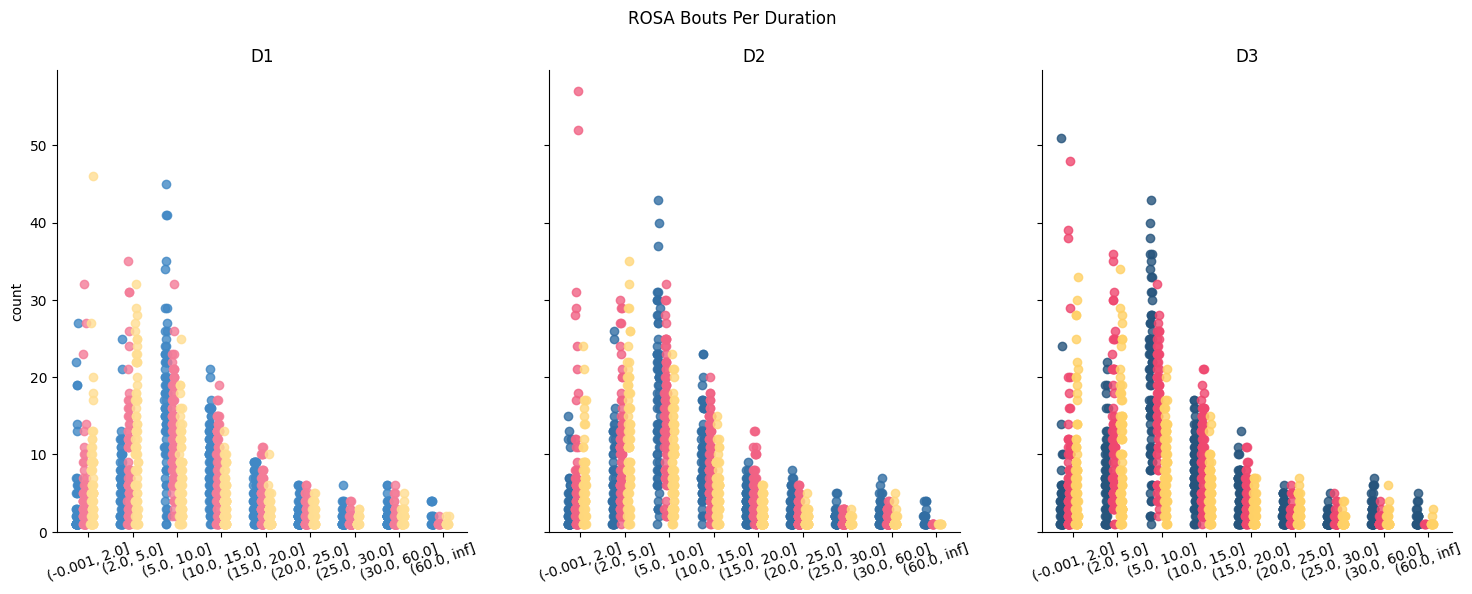

In [5]:
# general binning - current use is binning by bout duration but can be easily changed to break down data in your own way
general_bins = [0, 2, 5, 10, 15, 20, 25, 30, 60, float('inf')]  # currently set for duration
bouts_binned = bouts_df.copy()
bouts_binned['general bins'] = pd.cut(bouts_df['duration'], bins=general_bins, include_lowest=True)  # bin duration column

# target_col can be anything here since we're just counting up the amount of instances a bin has
scatter_bar_plot_binned(bouts_binned, conditions, days, rosa=1, target_col='duration',
                        agg_func='count', colors=colors, ylab='count',
                        plot_title='ROSA Bouts Per Duration')

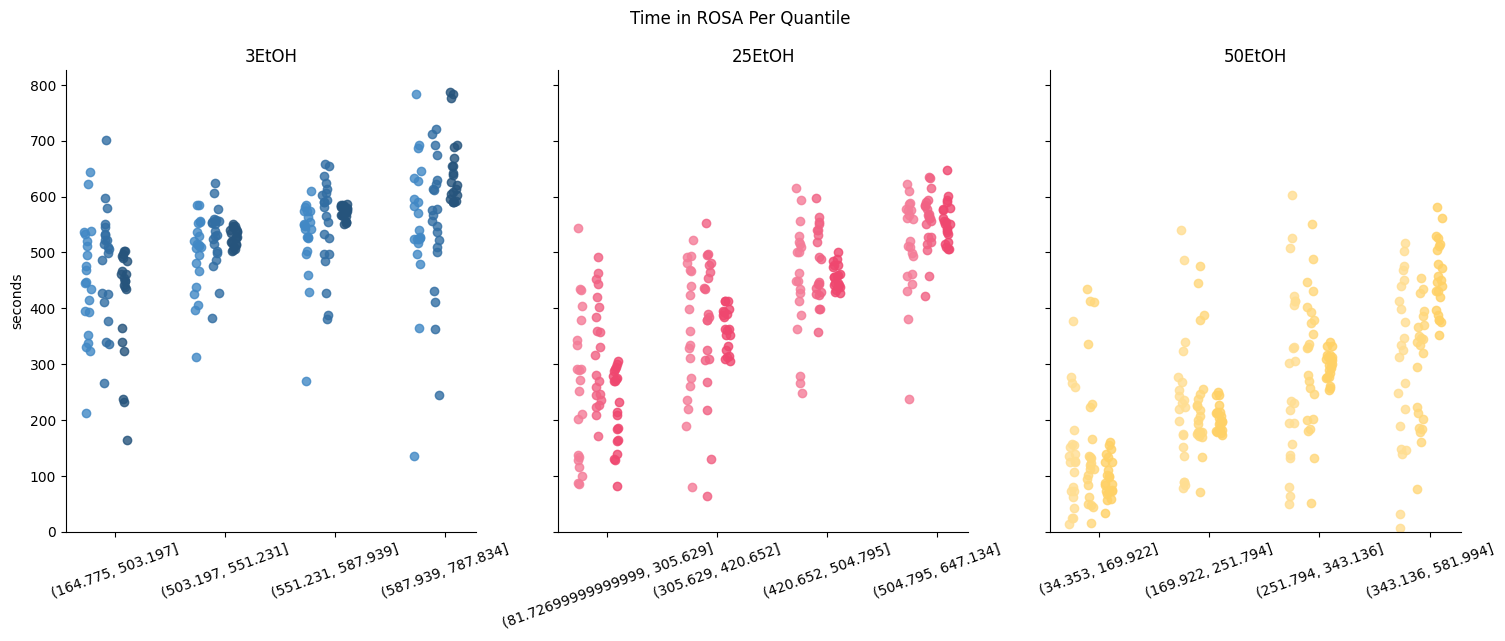

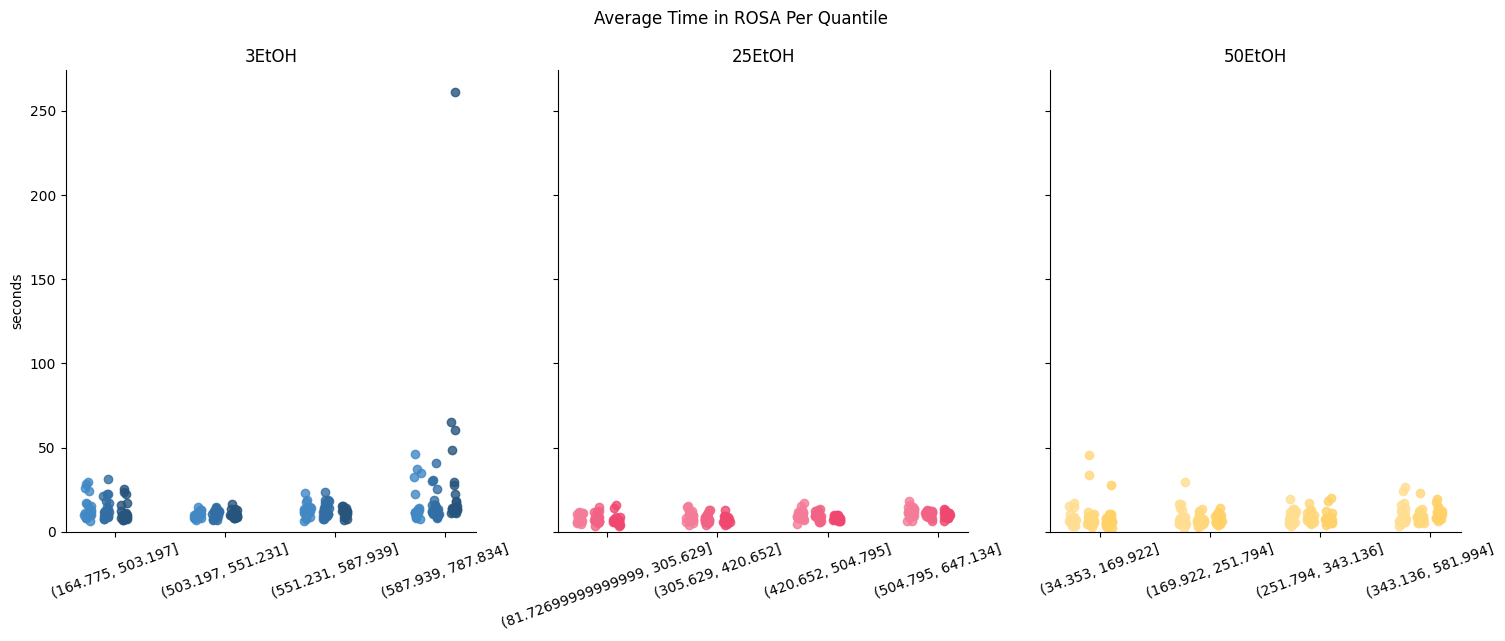

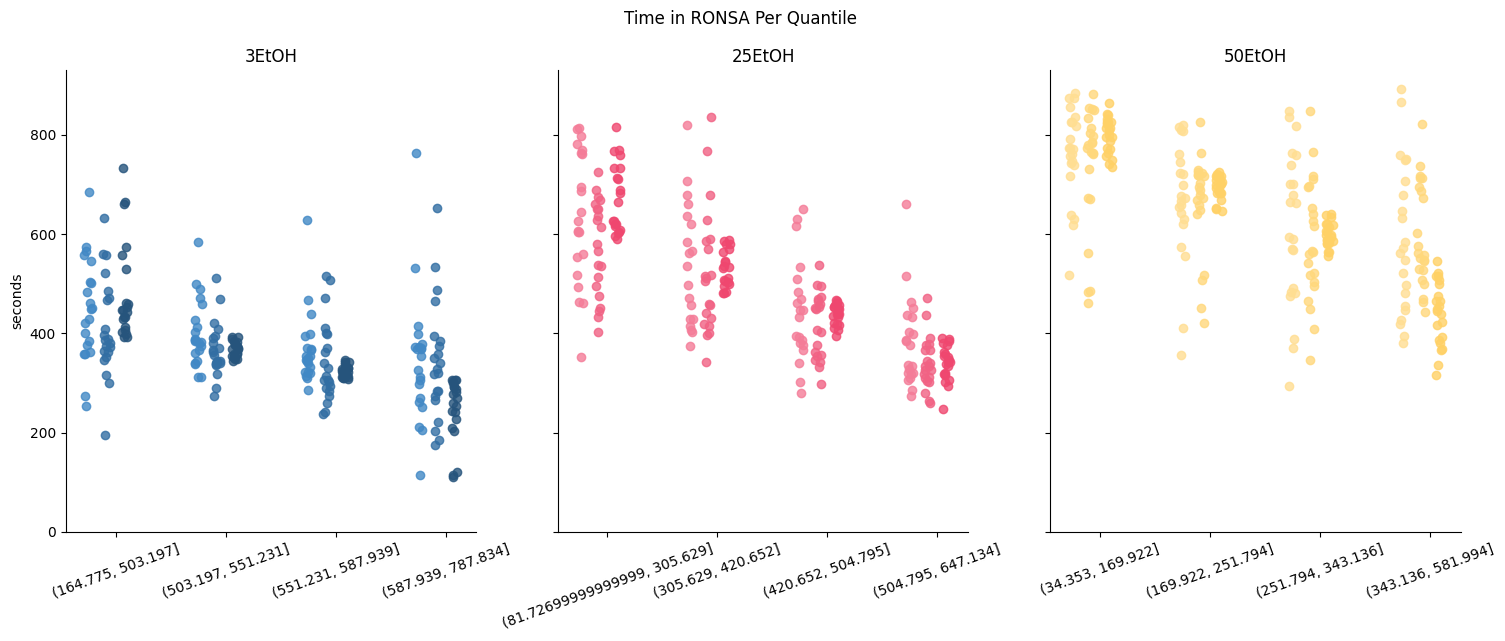

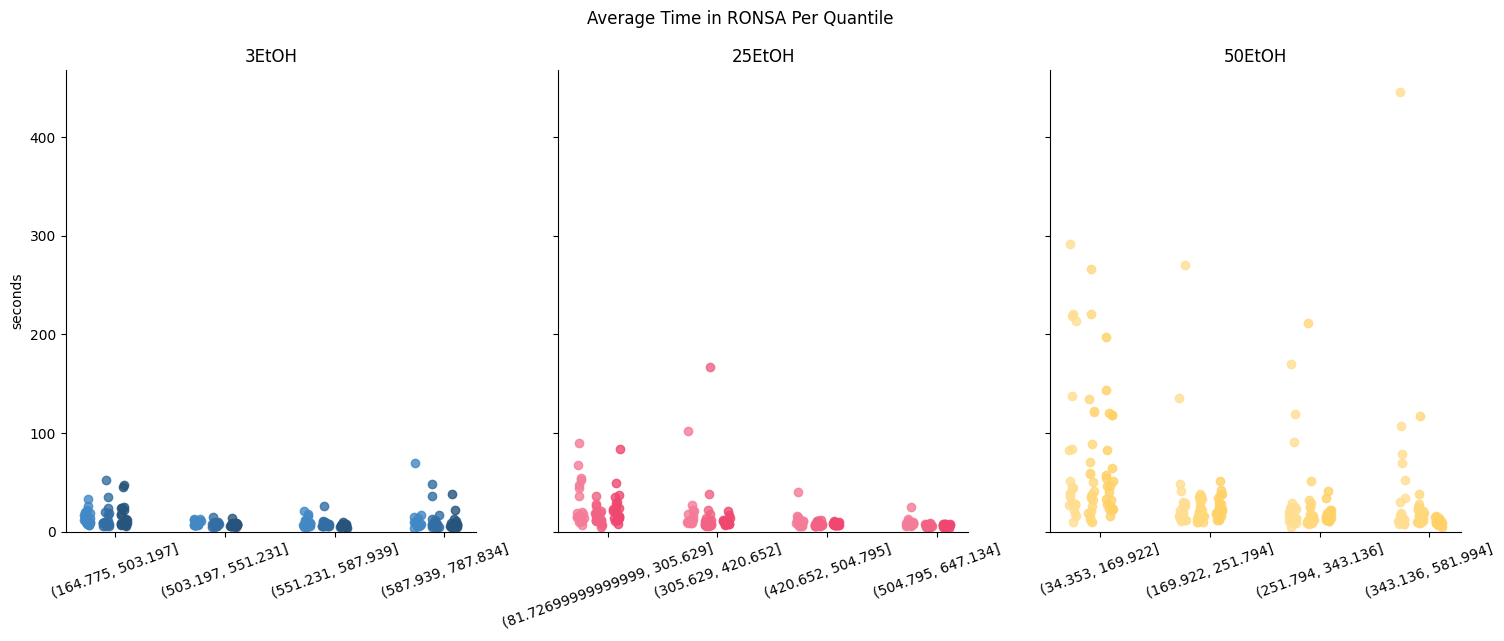

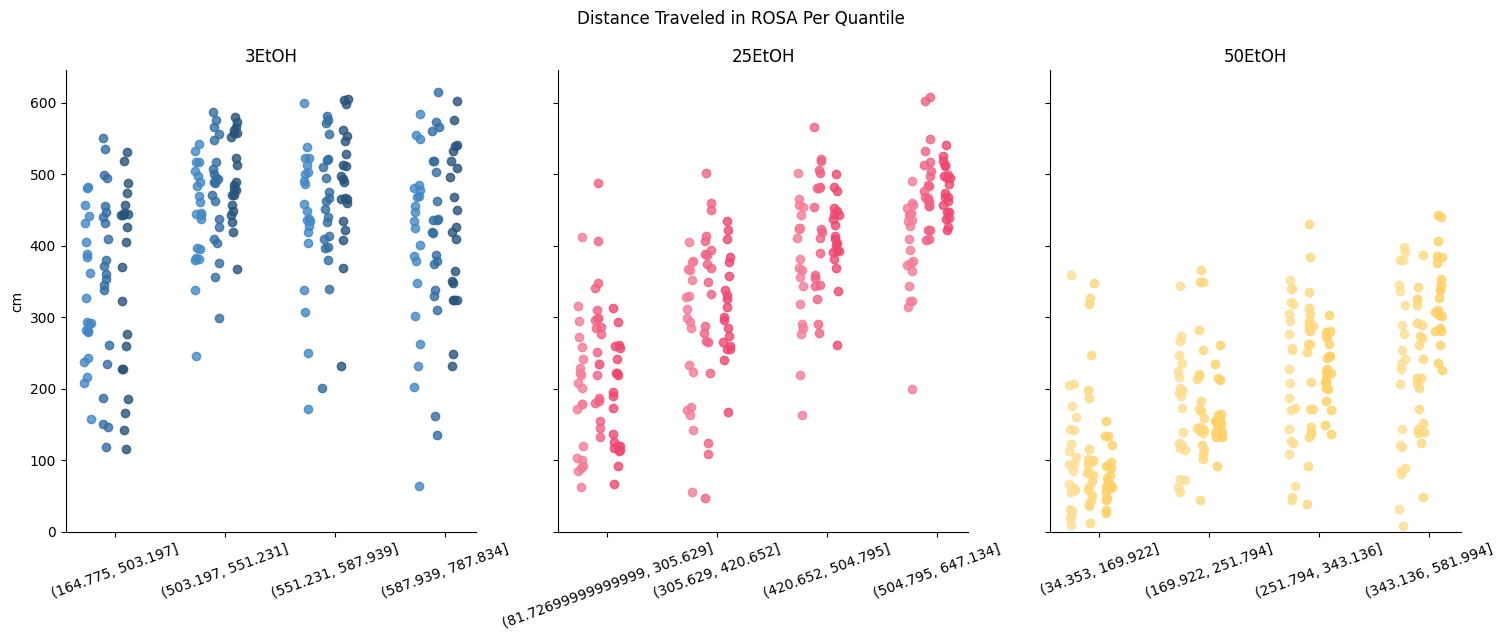

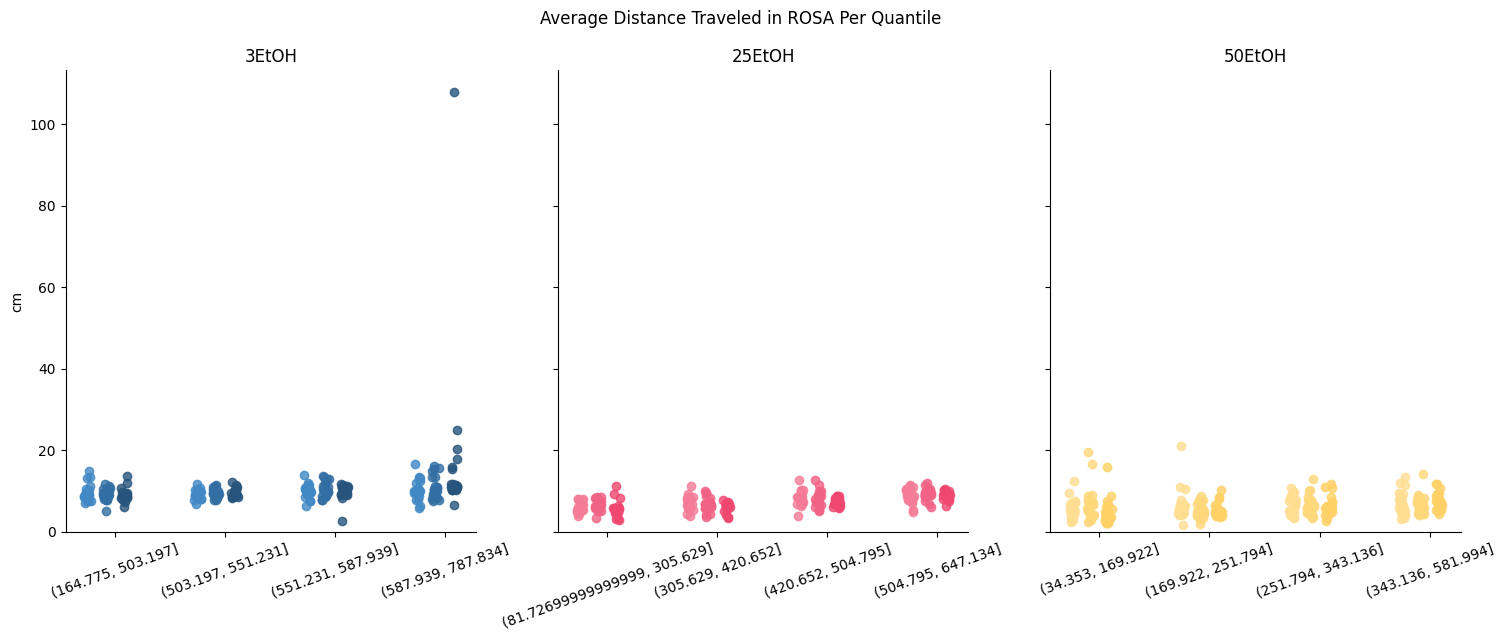

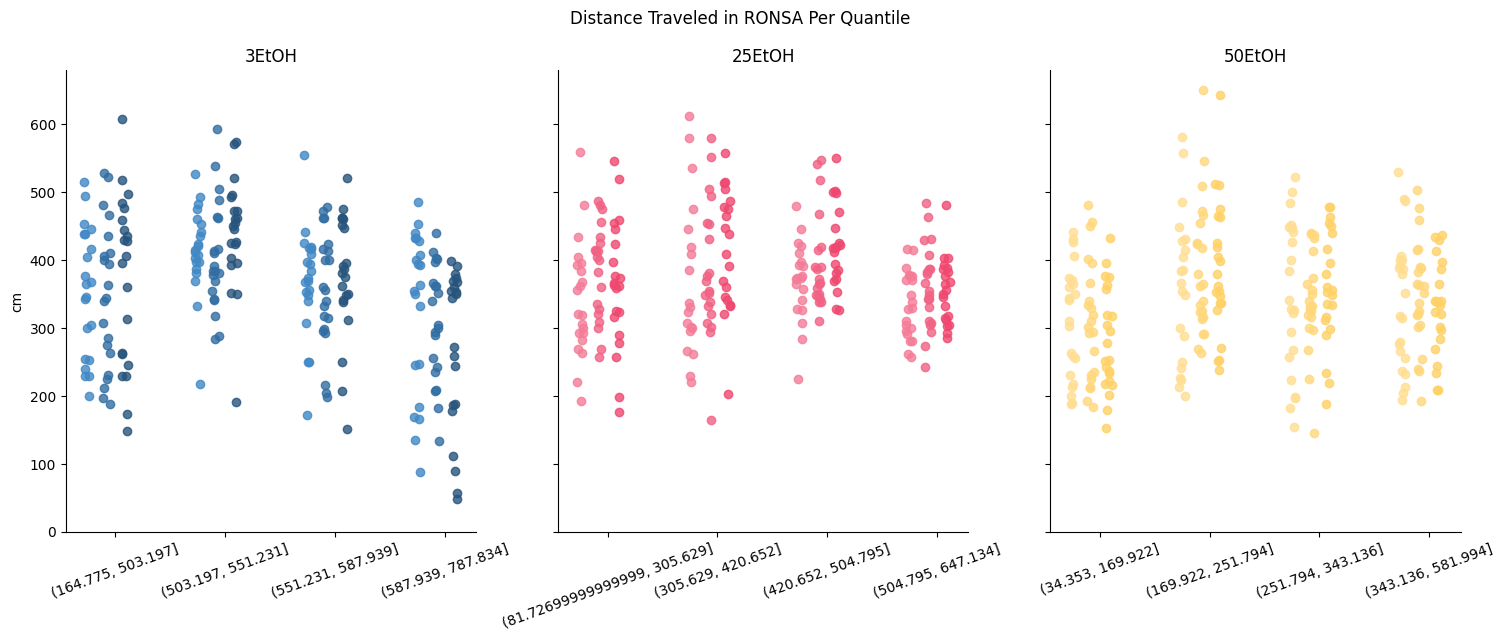

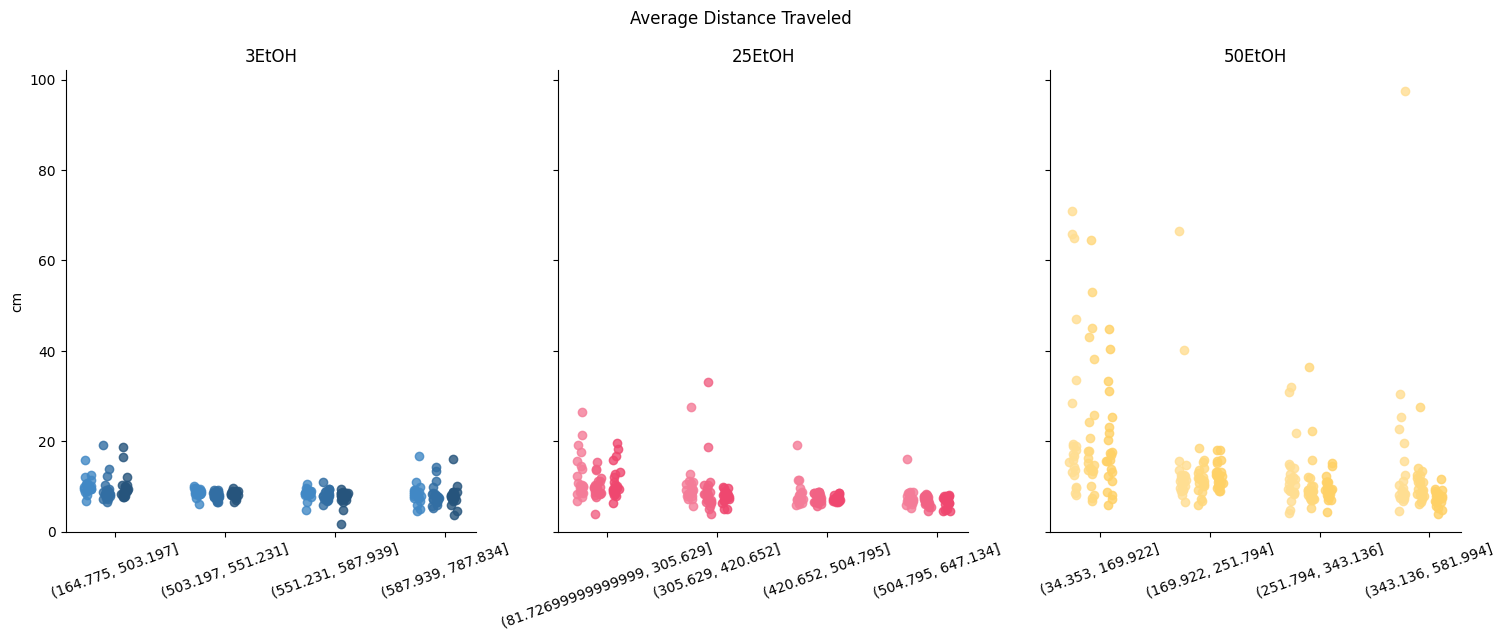

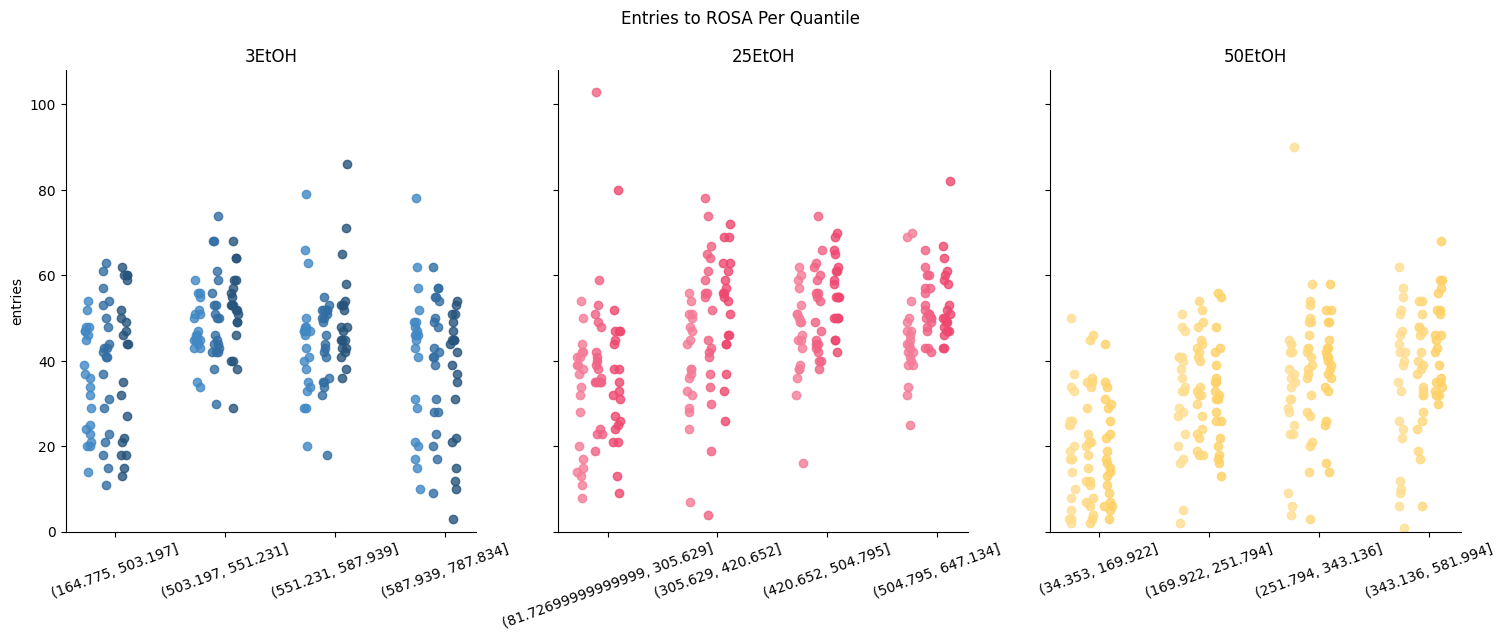

In [14]:
# quantiles binning - assign bouts data to quantiles and returns the quantiles for reference (quartiles by default)
quantiles_df, quantiles = get_quantiles(bouts_df, conditions)
quantiles_df = quantiles_df.dropna()  # in sample data, some flies dont have the same id leading to some NA

# total/avg time in rosa per quantile
scatter_bar_plot_quantile(quantiles_df, conditions, days, rosa=1,
                          target_col='duration', agg_func='sum', colors=colors,
                          ylab='seconds', plot_title='Time in ROSA Per Quantile')
scatter_bar_plot_quantile(quantiles_df, conditions, days, rosa=1,
                          target_col='duration', agg_func='mean', colors=colors,
                          ylab='seconds', plot_title='Average Time in ROSA Per Quantile')

# total/avg time in ronsa
scatter_bar_plot_quantile(quantiles_df, conditions, days, rosa=0,
                          target_col='duration', agg_func='sum', colors=colors,
                          ylab='seconds', plot_title='Time in RONSA Per Quantile')
scatter_bar_plot_quantile(quantiles_df, conditions, days, rosa=0,
                          target_col='duration', agg_func='mean', colors=colors,
                          ylab='seconds', plot_title='Average Time in RONSA Per Quantile')

# total/avg distance in rosa
scatter_bar_plot_quantile(quantiles_df, conditions, days, rosa=1,
                          target_col='distance', agg_func='sum', colors=colors,
                          ylab='cm', plot_title='Distance Traveled in ROSA Per Quantile')
scatter_bar_plot_quantile(quantiles_df, conditions, days, rosa=1,
                          target_col='distance', agg_func='mean', colors=colors,
                          ylab='cm', plot_title='Average Distance Traveled in ROSA Per Quantile')

# total/avg distance in ronsa
scatter_bar_plot_quantile(quantiles_df, conditions, days, rosa=0,
                          target_col='distance', agg_func='sum', colors=colors,
                          ylab='cm', plot_title='Distance Traveled in RONSA Per Quantile')
scatter_bar_plot_quantile(quantiles_df, conditions, days, rosa=0,
                          target_col='distance', agg_func='mean', colors=colors,
                          ylab='cm', plot_title='Average Distance Traveled')

# entries
scatter_bar_plot_quantile(quantiles_df, conditions, days, rosa=1,
                          target_col='entry', agg_func='sum', colors=colors,
                          ylab='entries', plot_title='Entries to ROSA Per Quantile')